Group  member:

*   Phan Manh TUNG

*   Yuqiang MA


*   Zhongyuan WU

**(Our work begins with completing the document "A first analysis of the COMPAS dataset", which is section 1, subsection 2.1 and subsection 3.1. All other sections are our work of further exploration.)**

# 1 First analysis of data


## 1.1 Dataset description

We will examine the ProPublica COMPAS dataset, which contains the records of all criminal defendants who were subject to COMPAS screening in Broward County, Florida, during 2013 and 2014. For each defendant, various information fields (‘features’) were gathered by ProPublica. Broadly, these fields are related to the defendant’s demographic information (e.g., gender and race), criminal history (e.g., the number of prior offenses) and administrative information about the case (e.g., the case number, arrest date). Finally, the dataset contains the risk of recidivism predicted by the COMPAS tool, and also information about whether the defendant did actually recidivate or not (ground truth label for us).

The COMPAS score uses answers to 137 questions to assign a risk score to defendants -- essentially an estimate of the likelihood of re-arrest. The actual output is two-fold: a risk rating of 1-10 and a "low", "medium", or "high" risk label.

Link to dataset: https://github.com/propublica/compas-analysis

The file we will analyze is: compas-scores-two-years.csv

Link to the ProPublica article:

https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing

Some of the code below is adapted from the Propublica github repository above, and from

https://investigate.ai/propublica-criminal-sentencing/week-5-1-machine-bias-class/

## 1.2 Download the data

We first need to load the data from the ProPublica repo:
https://github.com/propublica/compas-analysis

In [ ]:
%matplotlib inline

import urllib.request
import os,sys
import numpy as np
import pandas as pd

from sklearn import feature_extraction
from sklearn import preprocessing
from random import seed, shuffle

SEED = 1234
seed(SEED)
np.random.seed(SEED)

def check_data_file(fname):
    files = os.listdir(".") # get the current directory listing
    print("Looking for file '%s' in the current directory...",fname)

    if fname not in files:
        print("'%s' not found! Downloading from GitHub...",fname)
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print("'%s' download and saved locally..",fname)
    else:
        print("File found in current directory..")
    
COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
check_data_file(COMPAS_INPUT_FILE)  

Looking for file '%s' in the current directory... compas-scores-two-years.csv
'%s' not found! Downloading from GitHub... compas-scores-two-years.csv
'%s' download and saved locally.. compas-scores-two-years.csv


## 1.3 Loading and cleaning data

The following code load the data using pandas and cleans it according to ProPublica's cleaning: 

"
If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.

We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.

In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed

We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility." 
"

Finally, it converts the data to a dictionary with np arrays, which will be useful later

In [ ]:
# load the file
df = pd.read_csv(COMPAS_INPUT_FILE)
# print(df.shape)

df = df.dropna(subset=["days_b_screening_arrest"]) # dropping missing vals

df = df[
    (df.days_b_screening_arrest <= 30) &  
    (df.days_b_screening_arrest >= -30) &  
    (df.is_recid != -1) &
    (df.c_charge_degree != 'O') &
    (df.score_text != 'N/A')
]

df.reset_index(inplace=True, drop=True) # renumber the rows from 0 again
# df.shape

# Conversion to dictionary with np arrays
data = df.to_dict('list')
for k in data.keys():
    data[k] = np.array(data[k])

## 1.4 Exploring the dataset

The following pandas commands are very convenient to explore the data. Uncomment them to explore the data. 

<span style="color:red">TODO</span>: Add a command to print the number of defendents per race. 

In the following, we will look mostly at African-Americans and Caucasians(termed blacks and whites for short)

In [ ]:
df.head(3)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1


In [ ]:
df.describe()

,id,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,is_recid,r_days_from_arrest,violent_recid,is_violent_recid,decile_score.1,v_decile_score,priors_count.1,start,end,event,two_year_recid
count,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,1997.000000,0.0,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000
mean,5509.259883,34.534511,0.059300,4.418503,0.091218,0.110661,3.246436,-1.740279,24.903273,0.484446,20.100651,NaN,0.112119,4.418503,3.641769,3.246436,13.316753,555.049417,0.389825,0.455120
std,3171.878516,11.730938,0.463599,2.839463,0.497872,0.470731,4.743770,5.084709,276.812982,0.499799,76.543499,NaN,0.315539,2.839463,2.488768,4.743770,50.138185,400.258400,0.487750,0.498022
min,1.000000,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-30.000000,0.000000,0.000000,-1.000000,NaN,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2753.750000,25.000000,0.000000,2.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,2.000000,1.000000,0.000000,0.000000,148.000000,0.000000,0.000000
50%,5521.000000,31.000000,0.000000,4.000000,0.000000,0.000000,1.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,4.000000,3.000000,1.000000,0.000000,539.500000,0.000000,0.000000
75%,8225.250000,42.000000,0.000000,7.000000,0.000000,0.000000,4.000000,-1.000000,1.000000,1.000000,1.000000,NaN,0.000000,7.000000,5.000000,4.000000,3.000000,914.000000,1.000000,1.000000
max,11001.000000,96.000000,20.000000,10.000000,13.000000,9.000000,38.000000,30.000000,9485.000000,1.000000,993.000000,NaN,1.000000,10.000000,10.000000,38.000000,937.000000,1186.000000,1.000000,1.000000


In [ ]:
# df.head() # check some examples of data
# df.columns # prints the features
# df.isnull().sum() #check for missing values
# df.describe() # generates descriptive statistics (e.g., to check for outliers)
# df.race.unique() # different races we have in the dataset
print("Age Categories")
print(df.age_cat.value_counts()) #number of people by age category
print("\nScore Categories")
print(df.score_text.value_counts()) #number of people by COMPAS risk category

# TODO: Insert your code below this
print("\nRace Categories")
print(df['race'].value_counts())

Age Categories
25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: age_cat, dtype: int64

Score Categories
Low       3421
Medium    1607
High      1144
Name: score_text, dtype: int64

Race Categories
African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64


In [ ]:
print('''
Attribute explanation:

age: The age of the individual at the time of their arrest or booking.

c_charge_degree: The degree of the criminal charge, either felony or misdemeanor.

race: The race of the individual.

sex: The gender of the individual.

priors_count: The number of prior criminal convictions the individual has.

juv_fel_count: The number of prior juvenile felony convictions the individual has.

juv_misd_count: The number of prior juvenile misdemeanor convictions the individual has.

is_recid: A binary variable indicating whether the individual was re-arrested within two years of their initial arrest.

score_text: A text-based score from the COMPAS algorithm indicating the individual's risk of recidivism.

decile_score: A numerical score from the COMPAS algorithm indicating the individual's risk of recidivism, on a scale from 1 to 10.
'''
)


Attribute explanation:

age: The age of the individual at the time of their arrest or booking.

c_charge_degree: The degree of the criminal charge, either felony or misdemeanor.

race: The race of the individual.

sex: The gender of the individual.

priors_count: The number of prior criminal convictions the individual has.

juv_fel_count: The number of prior juvenile felony convictions the individual has.

juv_misd_count: The number of prior juvenile misdemeanor convictions the individual has.

is_recid: A binary variable indicating whether the individual was re-arrested within two years of their initial arrest.

score_text: A text-based score from the COMPAS algorithm indicating the individual's risk of recidivism.

decile_score: A numerical score from the COMPAS algorithm indicating the individual's risk of recidivism, on a scale from 1 to 10.



## 1.5 Basic analysis of the bias in COMPAS scores

We now look at the COMPAS scores (deciles first, then text scores) as a function of the sensitive attribute (race or gender) to observe potential differences. 

We start by observing the scores for different groupes. 

<span style="color:red">TODO</span> (Done): Plot the histograms of decile scores for Black and White defendant and observe the difference. 


The distribution of these scores for 6,172 defendants who had not been arrested for a new offense or who had recidivated within two years.

These histograms show that scores for white defendants were skewed toward lower-risk categories, 
while black defendants were evenly distributed across scores.



Text(0.5, 0, 'Score decile')

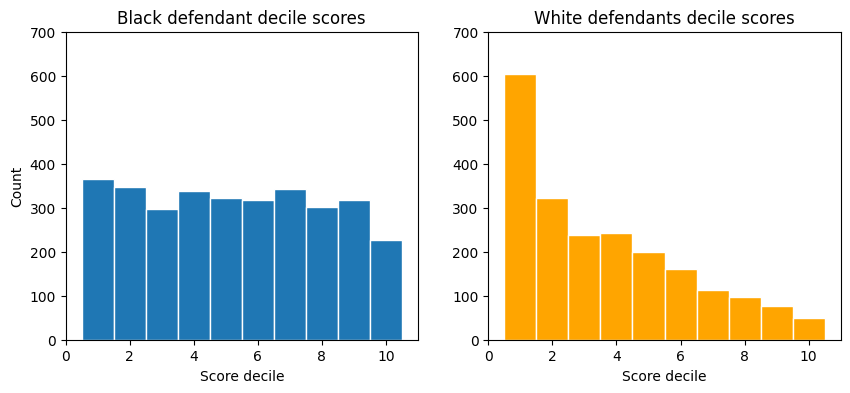

In [ ]:
# Histogram of decile scores for Blacks (blue) and Whites (orange)
# TODO: Insert your code below this
from matplotlib import pyplot as plt

print('''
The distribution of these scores for 6,172 defendants who had not been arrested for a new offense or who had recidivated within two years.

These histograms show that scores for white defendants were skewed toward lower-risk categories, 
while black defendants were evenly distributed across scores.
'''
)

fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(10, 4))
#fig.suptitle('Horizontally stacked subplots')

black_df = df[df['race'] == 'African-American']
black_df['decile_score'].hist(edgecolor='white', ax=ax1, bins=np.arange(13)-0.5,grid=False)
ax1.set_ylim([0,700])
ax1.set_xlim([0,11])
ax1.set_title('Black defendant decile scores')
ax1.set_xlabel('Score decile')
ax1.set_ylabel('Count')


black_df = df[df['race'] == 'Caucasian']
ax2 = black_df['decile_score'].hist(edgecolor='white', ax=ax2, color="orange", bins=np.arange(13)-0.5,grid=False)

ax2.set_ylim([0,700])
ax2.set_xlim([0,11])
ax2.set_title('White defendants decile scores')
ax2.set_xlabel('Score decile')

The above observation can be explained by a dependence between the race and true label.

In [ ]:
# recidivism rates by race

# true lable: two_year_recid
# prediction: decile_score (1-10), score_text (Low, Medium, High)

recid_race = pd.crosstab(df.race, df.two_year_recid)
recid_race['rate'] = recid_race[1] / recid_race.sum(axis=1)
recid_race

two_year_recid,0,1,rate
race,,,
African-American,1514,1661,0.523150
Asian,23,8,0.258065
Caucasian,1281,822,0.390870
Hispanic,320,189,0.371316
Native American,6,5,0.454545
Other,219,124,0.361516


We now look at whether we observe a similar phenomenon on the text scores of COMPAS (low, medium, high risk).

In [ ]:
# high risk rates by race
score_race = pd.crosstab(df.race, df.score_text)
score_race['High risk rate'] = score_race['High'] / score_race.sum(axis=1)
score_race

score_text,High,Low,Medium,High risk rate
race,,,,
African-American,845,1346,984,0.266142
Asian,3,24,4,0.096774
Caucasian,223,1407,473,0.106039
Hispanic,47,368,94,0.092338
Native American,4,3,4,0.363636
Other,22,273,48,0.064140


# 2. Fairness metrics for the COMPAS scores


## 2.1 Exploring the fairness

We do not have the actual scores that are used to compte text scores Low-Med-High; hence we cannot investigate directly the calibration. However, we can use the decile score as a proxy, and we can investigate PPV. 

Let us first plot the probability of recidivism by decile score. We observe that it is not very far from a diagonale.

<ipython-input-10-a0e04be3a8d7>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(df.decile_score).mean()['two_year_recid'].plot(kind='bar')


<Axes: xlabel='decile_score'>

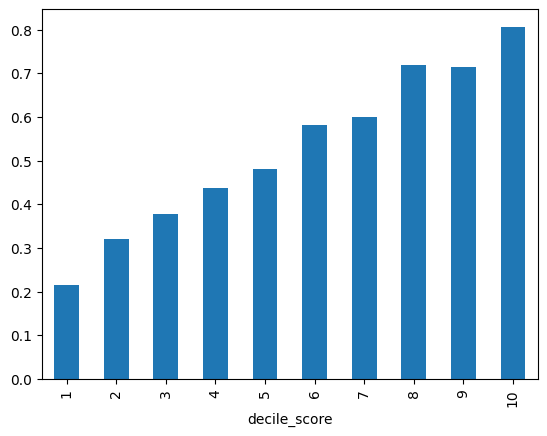

In [ ]:
# probability of recidivism by decile
df.groupby(df.decile_score).mean()['two_year_recid'].plot(kind='bar')

<span style="color:red">TODO</span>(Done): Plot a similar graph with separated bars for Blacks and Whites. 

<ipython-input-11-3b4eb4c5c478>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd.DataFrame([df.loc[df["race"].isin(['African-American'])].groupby(df.decile_score).mean()['two_year_recid'].rename("Black"),
<ipython-input-11-3b4eb4c5c478>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.loc[df["race"].isin(['Caucasian'])].groupby(df.decile_score).mean()['two_year_recid'].rename("White")


<Axes: xlabel='decile_score'>

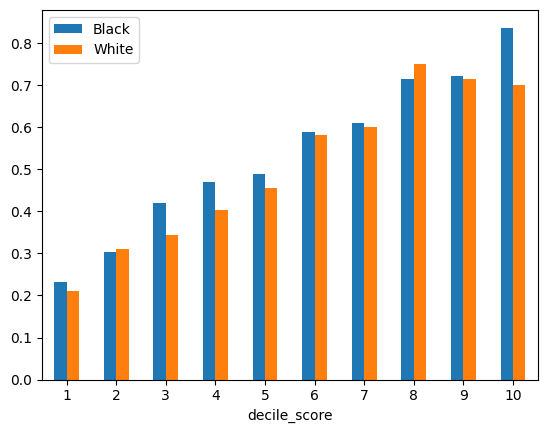

In [ ]:
pd.DataFrame([df.loc[df["race"].isin(['African-American'])].groupby(df.decile_score).mean()['two_year_recid'].rename("Black"),
              df.loc[df["race"].isin(['Caucasian'])].groupby(df.decile_score).mean()['two_year_recid'].rename("White")
              ]).T.plot.bar(rot=0)

In [ ]:
# probability of recidivism by decile and race
# TODO: Insert your code below this

# recidivism rates by race
recid_race = pd.crosstab(df.race, df.two_year_recid)
recid_race['rate'] = recid_race[1] / recid_race.sum(axis=1)
recid_race

two_year_recid,0,1,rate
race,,,
African-American,1514,1661,0.523150
Asian,23,8,0.258065
Caucasian,1281,822,0.390870
Hispanic,320,189,0.371316
Native American,6,5,0.454545
Other,219,124,0.361516


In [ ]:
# recidivism rates by decile
recid_decile = pd.crosstab(df.decile_score, df.two_year_recid)
recid_decile['rate'] = recid_decile[1] / recid_decile.sum(axis=1)
recid_decile

two_year_recid,0,1,rate
decile_score,,,
1,1009,277,0.215397
2,558,264,0.321168
3,403,244,0.377125
4,375,291,0.436937
5,302,280,0.481100
6,221,308,0.582231
7,198,298,0.600806
8,118,302,0.719048
9,120,300,0.714286


To further analyze the COMPAS score as a classifier, we transform it into a binary outcome by splitting "low" (class 0) from "medium or high" risk (class 1). We can then compute standard quantities such as the confusion matrix or PPV.

In [ ]:
# COMPAS recidivism confusion matrix
df['guessed_recid'] = df.score_text != 'Low'
df['actual_recid'] = df.two_year_recid == 1
cm = pd.crosstab(df.actual_recid, df.guessed_recid)
cm # for "confusion matrix"

guessed_recid,False,True
actual_recid,,
False,2345,1018
True,1076,1733


We finally compute the PPV, TPR and FPR of the COMPAS classifier. 

<span style="color:red">TODO</span>(Done): Complete the print_ppv_fpv function. Observe the differences in the metrics between Blacks and Whites and comment. 

In [ ]:
# cm is a confusion matrix. The rows are guessed, the columns are actual 
def print_ppv_fpv(cm):
    # the indices here are [col][row] or [actual][guessed]
    TN = cm[False][False]   
    TP = cm[True][True]
    FN = cm[True][False]
    FP = cm[False][True]
# TODO: Uncomment the lines below and replace the ... by the appropriate expressions of TN, TP, FN, FP  
    print('Accuracy: ', (TN+TP)/(TN+TP+FN+FP))
    print('PPV: ', TP / (TP + FP)) # PPV or TPR ? same
    print('FPR: ', FP / (FP + TN))
    print('FNR: ', FN / (FN + TP))
    print()


def print_metrics(guessed, actual):
    cm = pd.crosstab(guessed, actual, rownames=['guessed'], colnames=['actual'])
    print(cm)
    print()
    print_ppv_fpv(cm)   
    
print('White')
subset = df[df.race == 'Caucasian']
print_metrics(subset.guessed_recid, subset.actual_recid)

print('Black')
subset = df[df.race == 'African-American']
print_metrics(subset.guessed_recid, subset.actual_recid)


White
actual   False  True 
guessed              
False      999    408
True       282    414

Accuracy:  0.6718972895863052
PPV:  0.5948275862068966
FPR:  0.22014051522248243
FNR:  0.49635036496350365

Black
actual   False  True 
guessed              
False      873    473
True       641   1188

Accuracy:  0.6491338582677165
PPV:  0.6495352651722253
FPR:  0.4233817701453104
FNR:  0.2847682119205298



We can see: the False Positive Rate is substantially higher for black defendants, but the PPV is similar between blacks and whites. That is, the COMPAS score satisfies sufficiency, but not separation. 

## 2.2 Fairness metrics that we use
From the lecture about fairness, we can know there are 3 laws of fairness:

### Law 1. Independence: (also called demographic parity)
Independence means equal proportion of positive outcomes (Yˆ = 1) in
each population. So we evaluate the value (TP + FP)/(TP + FP + TN + FN) in each ethnic group, to make their difference as small as possible.

### Law 2. Separation: (also called predictive value parity)
Separation means equal false positive/negative rates (Yˆ ̸= Y ) in each population. So we evaluate False Positive Rate and False Negative Rate in each ethnic group, to make the corresponding rate in each ethnic group to be as same as possible.

### Law 3. Sufficiency:
Sufficiency means equal true positive/negative rates in each population. So we evaluate True Positive Rate and True Negative Rate in each ethnic group, to make the corresponding rate in each ethnic group to be as same as possible.



Note that these 3 laws contradict to each other to some extent. We may need to find some trade-off between fairness metrics, and between the accuracy of the model. 

We implement a function "evaluate_fairness" to print the differences of the metrics above(Positive proportion, FPR, FNR, TPR, TNR) between two groups. The smaller the differences are, the more fair classifier we get. The function also calls the "print_metrics" function implemented above, to keep the useful informations inside it for analysis(such as Accuracy).

**This function "evaluate_fairness" will be used to evaluate fairness in all following models.** Our aim is to minimize all fairness metrics, but because of contradiction, maybe not all of these 5 differences can be small. We need to observe and make trade-offs.


In [ ]:
def evaluate_fairness(predicted_race1, actual_race1, predicted_race2, actual_race2):
    # cm is a confusion matrix. (I am not sure if I use crosstab correctly)
    # Confusion matrix for race 1 
    cm1 = pd.crosstab(predicted_race1, actual_race1, rownames=['predicted'], colnames=['actual'])
    TN1 = cm1[False][False]   
    TP1 = cm1[True][True]
    FN1 = cm1[True][False]
    FP1 = cm1[False][True]

    Prop_positive1 = (TP1 + FP1)/(TN1 + TP1 + FN1 + FP1)

    FPR1 = FP1 / (FP1 + TN1)
    FNR1 = FN1 / (FN1 + TP1)

    TPR1 = TP1 / (TP1 + FN1)
    TNR1 = TN1 / (TN1 + FP1)

    # Confusion matrix for race 2
    cm2 = pd.crosstab(predicted_race2, actual_race2, rownames=['predicted'], colnames=['actual'])
    TN2 = cm2[False][False]   
    TP2 = cm2[True][True]
    FN2 = cm2[True][False]
    FP2 = cm2[False][True]

    Prop_positive2 = (TP2 + FP2)/(TN2 + TP2 + FN2 + FP2)

    FPR2 = FP2 / (FP2 + TN2)
    FNR2 = FN2 / (FN2 + TP2)

    TPR2 = TP2 / (TP2 + FN2)
    TNR2 = TN2 / (TN2 + FP2)
    print("---------Result of Print_Metrics in group 1---------")
    print_ppv_fpv(cm1) 
    print("---------Result of Print_Metrics in group 2---------")
    print_ppv_fpv(cm2) 
    Independence = abs(Prop_positive1 - Prop_positive2)
    print("---------Independence performance---------")
    print("positive rate 1 is %f, positive rate 2 is %f, difference is %f" %(Prop_positive1, Prop_positive2, Independence))

    Separation_FPR = abs(FPR1 - FPR2)
    Separation_FNR = abs(FNR1 - FNR2)
    print("---------Separation performance---------")
    print("FPR 1 is %f, FPR 2 is %f, difference is %f" %(FPR1, FPR2, Separation_FPR))
    print("FNR 1 is %f, FNR 2 is %f, difference is %f" %(FNR1, FNR2, Separation_FNR))

    Sufficiency_TPR = abs(TPR1 - TPR2)
    Sufficiency_TNR = abs(TNR1 - TNR2)
    print("---------Sufficiency performance---------")
    print("TPR 1 is %f, TPR 2 is %f, difference is %f" %(TPR1, TPR2, Sufficiency_TPR))
    print("TNR 1 is %f, TNR 2 is %f, difference is %f" %(TNR1, TNR2, Sufficiency_TNR))

subset_white = df[df.race == 'Caucasian']
subset_black = df[df.race == 'African-American']

evaluate_fairness(subset_white.guessed_recid, subset_white.actual_recid, subset_black.guessed_recid, subset_black.actual_recid)

---------Result of Print_Metrics in group 1---------
Accuracy:  0.6718972895863052
PPV:  0.5948275862068966
FPR:  0.22014051522248243
FNR:  0.49635036496350365

---------Result of Print_Metrics in group 2---------
Accuracy:  0.6491338582677165
PPV:  0.6495352651722253
FPR:  0.4233817701453104
FNR:  0.2847682119205298

---------Independence performance---------
positive rate 1 is 0.330956, positive rate 2 is 0.576063, difference is 0.245107
---------Separation performance---------
FPR 1 is 0.220141, FPR 2 is 0.423382, difference is 0.203241
FNR 1 is 0.496350, FNR 2 is 0.284768, difference is 0.211582
---------Sufficiency performance---------
TPR 1 is 0.503650, TPR 2 is 0.715232, difference is 0.211582
TNR 1 is 0.779859, TNR 2 is 0.576618, difference is 0.203241


# 3 Training of different classifiers

## 3.1 Training a classifier from the ground truth label

We now train a classifier (a simple logistic regression) on the label two_year_recid. We work on a subset of features: ["age_cat", "race", "sex", "priors_count", "c_charge_degree"]. 

<span style="color:red">TODO</span>: Complete the model definition and fitting. 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import defaultdict

FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "priors_count", "c_charge_degree"] #features to be used for classification
CONT_VARIABLES = ["priors_count"] # continuous features, will need to be handled separately from categorical features, categorical features will be encoded using one-hot
CLASS_FEATURE = "two_year_recid" # the decision variable
SENSITIVE_ATTRS = ["race"]

y = data[CLASS_FEATURE]
X = np.array([]).reshape(len(y), 0) # empty array with num rows same as num examples, will hstack the features to it
x_control = defaultdict(list)

for attr in FEATURES_CLASSIFICATION:
    vals = data[attr]
    if attr in CONT_VARIABLES:
        vals = [float(v) for v in vals]
        vals = preprocessing.scale(vals) # 0 mean and 1 variance  
        vals = np.reshape(vals, (len(y), -1)) # convert from 1-d arr to a 2-d arr with one col

    else: # this encodes categorical variables in a numerical way -- there are other ways to do it
        enc = preprocessing.LabelBinarizer()
        enc.fit(vals)
        vals = enc.transform(vals)

    # add to learnable features
    X = np.hstack((X, vals))

    
# the following is a very dirty way to keep track of the race after the train_test_split    
ind = data["race"]=="African-American"
X_b = X[ind] 
y_b = y[ind]
ind = data["race"]=="Caucasian"
X_w = X[ind]        
y_w = y[ind]
ind = [data["race"][i]!="Caucasian" and data["race"][i]!="African-American" for i in range(len(y))]
X_n = X[ind]        
y_n = y[ind]
    
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.3, random_state=1234)
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_w, y_w, test_size=0.3, random_state=5678)
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, y_n, test_size=0.3, random_state=9012)

X_train = np.vstack((X_train_b, X_train_w, X_train_n))
y_train = np.hstack((y_train_b, y_train_w, y_train_n))

X_test = np.vstack((X_test_b, X_test_w, X_test_n))
y_test = np.hstack((y_test_b, y_test_w, y_test_n))

In [ ]:
# TODO: Uncomment and complete the code below
model = LogisticRegression(C=0.1)
model.fit(X_train, y_train)
#y_predict = model.predict(X_test)

LogisticRegression(C=0.1)

In [ ]:
model.score(X_test, y_test)

0.6562331354560172

We can then compute the model accuracy. Compare to the COMPAS accuracy. 

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.6562331354560172


We can also plot the ROC curve for the model on the global population. 

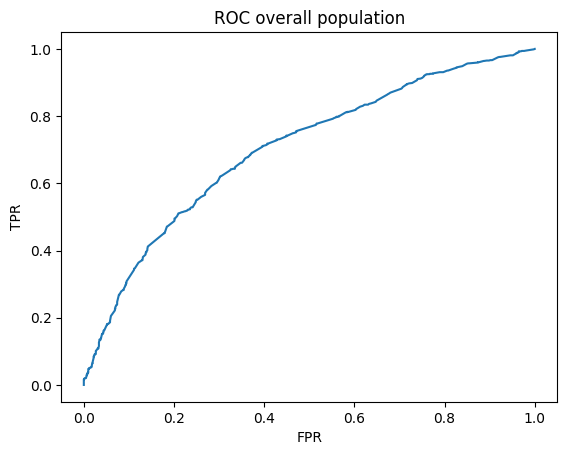

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

scores = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, scores[:,1])

plt.plot(fpr, tpr)

plt.title('ROC overall population')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

<span style="color:red">TODO</span>: Plot the ROC curve for Blacks and Whites in two separate curves (in the same plot). What do you observe?

Text(0, 0.5, 'TPR')

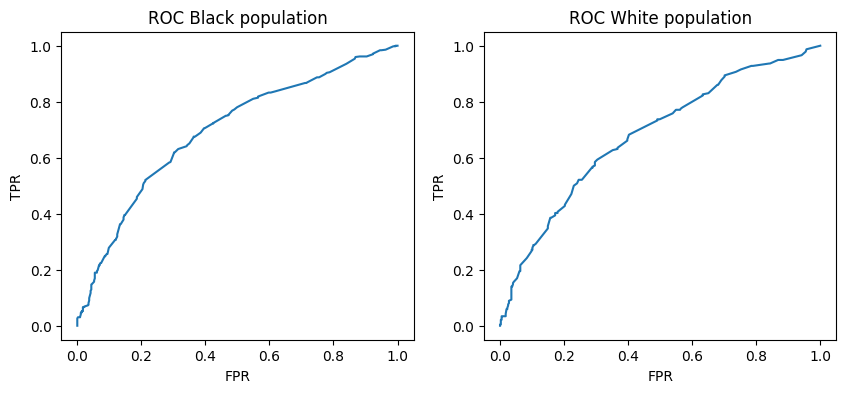

In [ ]:
from sklearn.metrics import roc_curve

from matplotlib import pyplot as plt

# TODO: Insert your code below this line

scores_b = model.predict_proba(X_test_b)
fpr, tpr, thresholds = roc_curve(y_test_b, scores_b[:,1])

fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(10, 4))
#fig.suptitle('Horizontally stacked subplots')

ax1.plot(fpr, tpr)

ax1.set_title('ROC Black population')
ax1.set_xlabel("FPR")
ax1.set_ylabel("TPR")

scores_w = model.predict_proba(X_test_w)
fpr, tpr, thresholds = roc_curve(y_test_w, scores_w[:,1])

ax2.plot(fpr, tpr)

ax2.set_title('ROC White population')
ax2.set_xlabel("FPR")
ax2.set_ylabel("TPR")

We can finally check the fairness of this simple logistic regression, when choosing an arbitrary threshold common to the two groups. 

<span style="color:red">TODO</span>: Compute the predictions for a common threshold (threshold_common), then compute the PPV, TPR, FPR (you can use the print_metrics function from above). Comment. 

In [ ]:
threshold_common = 0.5
# TODO: Insert your code below this line
y_pred_b = [True if prob >= threshold_common else False for prob in scores_b[:,1]]  # Binary predictions based on threshold_common
y_pred_w = [True if prob >= threshold_common else False for prob in scores_w[:,1]]  # Binary predictions based on threshold_common

y_test_b1 = [True if t==1 else False for t in y_test_b]
y_test_w1 = [True if t==1 else False for t in y_test_w]

# print_metrics is contained in this function we implemented
evaluate_fairness(y_pred_w, y_test_w1, y_pred_b, y_test_b1)

---------Result of Print_Metrics in group 1---------
Accuracy:  0.6687797147385103
PPV:  0.5828220858895705
FPR:  0.17215189873417722
FNR:  0.597457627118644

---------Result of Print_Metrics in group 2---------
Accuracy:  0.6505771248688352
PPV:  0.6687370600414079
FPR:  0.350109409190372
FNR:  0.3487903225806452

---------Independence performance---------
positive rate 1 is 0.258320, positive rate 2 is 0.506821, difference is 0.248500
---------Separation performance---------
FPR 1 is 0.172152, FPR 2 is 0.350109, difference is 0.177958
FNR 1 is 0.597458, FNR 2 is 0.348790, difference is 0.248667
---------Sufficiency performance---------
TPR 1 is 0.402542, TPR 2 is 0.651210, difference is 0.248667
TNR 1 is 0.827848, TNR 2 is 0.649891, difference is 0.177958


Finally, we can also investigate the calibration more finely using the calibration module from sklearn. 

<span style="color:red">TODO</span>: Complete the code below to plot the calibration curve for the whole population.

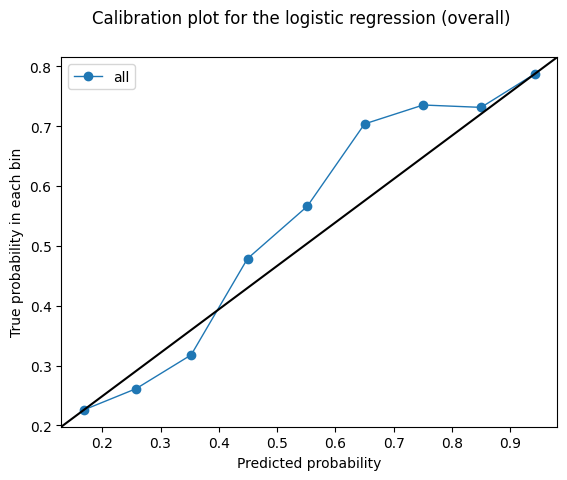

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

# TODO: Uncomment and complete the code below
scores = scores[:,1]
prob_true, prob_pred = calibration_curve(y_test, scores, n_bins=10)

fig, ax = plt.subplots()
# only this line is calibration curves
plt.plot(prob_pred,prob_true, marker='o', linewidth=1, label='all')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for the logistic regression (overall)')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

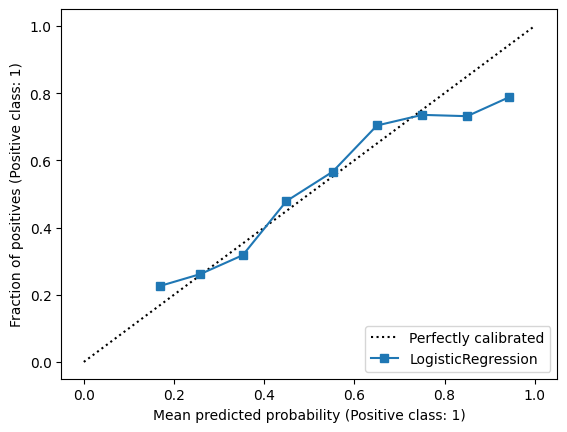

In [ ]:
# Another way to sketch the graph

from sklearn.calibration import CalibrationDisplay

disp = CalibrationDisplay.from_estimator(model, X_test, y_test, n_bins=10)
plt.show()

<span style="color:red">TODO</span>: Complete the code below to plot the calibration curve for the blacks and white separately. Conclude. 

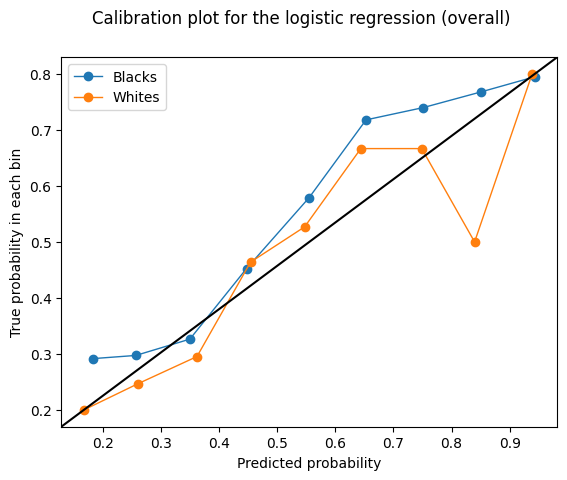

In [ ]:
# TODO: Uncomment and complete the code below
# ...
scores_b = scores_b[:,1]
prob_true_b, prob_pred_b = calibration_curve(y_test_b, scores_b, n_bins=10)
# ...
scores_w = scores_w[:,1]
prob_true_w, prob_pred_w = calibration_curve(y_test_w, scores_w, n_bins=10)

fig, ax = plt.subplots()
# only this line is calibration curves
plt.plot(prob_pred_b,prob_true_b, marker='o', linewidth=1, label='Blacks')
plt.plot(prob_pred_w,prob_true_w, marker='o', linewidth=1, label='Whites')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for the logistic regression (overall)')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

## 3.2 Principle Component Analysis

Dimension Reduction technique. Number of Principle Components: 2

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import defaultdict

FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "priors_count", "c_charge_degree"] #features to be used for classification
CONT_VARIABLES = ["priors_count"] # continuous features, will need to be handled separately from categorical features, categorical features will be encoded using one-hot
CLASS_FEATURE = "two_year_recid" # the decision variable
SENSITIVE_ATTRS = ["race"]

y = data[CLASS_FEATURE]
X = np.array([]).reshape(len(y), 0) # empty array with num rows same as num examples, will hstack the features to it
x_control = defaultdict(list)

for attr in FEATURES_CLASSIFICATION:
    vals = data[attr]
    if attr in CONT_VARIABLES:
        vals = [float(v) for v in vals]
        vals = preprocessing.scale(vals) # 0 mean and 1 variance  
        vals = np.reshape(vals, (len(y), -1)) # convert from 1-d arr to a 2-d arr with one col

    else: # this encodes categorical variables in a numerical way -- there are other ways to do it
        enc = preprocessing.LabelBinarizer()
        enc.fit(vals)
        vals = enc.transform(vals)

    # add to learnable features
    X = np.hstack((X, vals))

In [ ]:
from sklearn.decomposition import PCA

# n=2 -> reduce to only 2 dimensions
pca = PCA(n_components=2) # create a PCA object
pca.fit(X) # do the math
pca_data = pca.transform(X) # get PCA coordinates for scaled_data

In [ ]:
print(X.shape)
print(pca_data.shape)

(6172, 12)
(6172, 2)


[40.8 16. ]


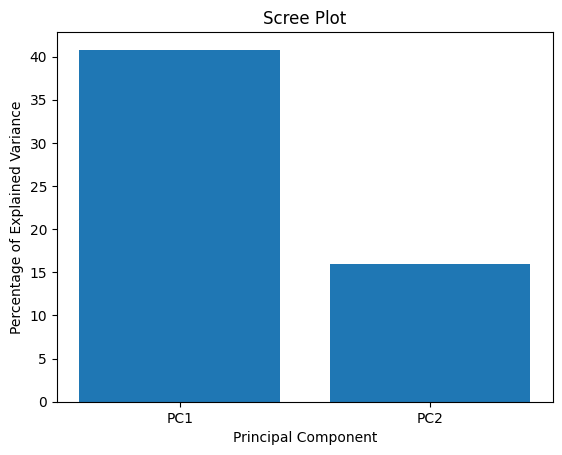

In [ ]:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
print(per_var)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

# First component - 40.8% ; Second 16%

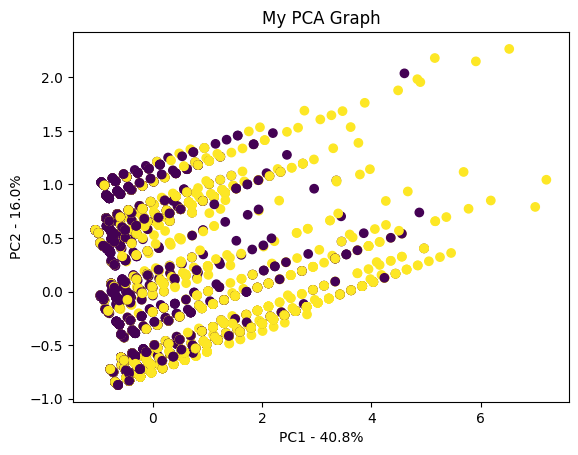

In [ ]:
# Plot the PC1, PC2 with the classified groups
pca_df = pd.DataFrame(pca_data, columns=labels)

plt.scatter(pca_df.PC1, pca_df.PC2, c=y)
plt.title('My PCA Graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
plt.show()

## 3.3 Apriori Algorithm: frequent item set mining and association rule learning

This algorithm finds connections between different categorical data fields, mainly used for Market Basket Analysis

In [ ]:
df.describe()

,id,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,is_recid,r_days_from_arrest,violent_recid,is_violent_recid,decile_score.1,v_decile_score,priors_count.1,start,end,event,two_year_recid
count,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,1997.000000,0.0,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000
mean,5509.259883,34.534511,0.059300,4.418503,0.091218,0.110661,3.246436,-1.740279,24.903273,0.484446,20.100651,NaN,0.112119,4.418503,3.641769,3.246436,13.316753,555.049417,0.389825,0.455120
std,3171.878516,11.730938,0.463599,2.839463,0.497872,0.470731,4.743770,5.084709,276.812982,0.499799,76.543499,NaN,0.315539,2.839463,2.488768,4.743770,50.138185,400.258400,0.487750,0.498022
min,1.000000,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-30.000000,0.000000,0.000000,-1.000000,NaN,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2753.750000,25.000000,0.000000,2.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,2.000000,1.000000,0.000000,0.000000,148.000000,0.000000,0.000000
50%,5521.000000,31.000000,0.000000,4.000000,0.000000,0.000000,1.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,4.000000,3.000000,1.000000,0.000000,539.500000,0.000000,0.000000
75%,8225.250000,42.000000,0.000000,7.000000,0.000000,0.000000,4.000000,-1.000000,1.000000,1.000000,1.000000,NaN,0.000000,7.000000,5.000000,4.000000,3.000000,914.000000,1.000000,1.000000
max,11001.000000,96.000000,20.000000,10.000000,13.000000,9.000000,38.000000,30.000000,9485.000000,1.000000,993.000000,NaN,1.000000,10.000000,10.000000,38.000000,937.000000,1186.000000,1.000000,1.000000


In [ ]:
print(np.unique(df["priors_count"].values))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 33 36 37 38]


In [ ]:
df_apriori=df[["age_cat", "race", "sex", "priors_count", "c_charge_degree","two_year_recid"]]

# Turn 4 categorical groups
df_apriori["priors_count"]=pd.cut(df_apriori["priors_count"],bins=[-0.01,9,19,29,38.99],labels=["1-9","10-19","20-29","30-38"])

<ipython-input-34-7e03c7c6f638>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_apriori["priors_count"]=pd.cut(df_apriori["priors_count"],bins=[-0.01,9,19,29,38.99],labels=["1-9","10-19","20-29","30-38"])


In [ ]:
df_apriori.nunique()

age_cat            3
race               6
sex                2
priors_count       4
c_charge_degree    2
two_year_recid     2
dtype: int64

In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

df1=df_apriori.copy().astype(str)
df1[df1.columns] = df1[df1.columns].apply(lambda row : str(row.name) + "==" + row)
dataset = df1.values.tolist()

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
r = pd.DataFrame(te_ary, columns=te.columns_)

# I choose a low min_support to preserve the class==bad (since there is only 300/1000 records for that class)
frequent_itemsets = apriori(r, min_support=0.25, use_colnames=True) # support > 0.25

# Lift / Conviction > 1 is a good measure to take (if that==1 proposes independency)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.001)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(age_cat==25 - 45),(race==African-American),0.572262,0.514420,0.307518,0.537373,1.044618,0.013135,1.049614
1,(race==African-American),(age_cat==25 - 45),0.514420,0.572262,0.307518,0.597795,1.044618,0.013135,1.063484
2,(age_cat==25 - 45),(two_year_recid==1),0.572262,0.455120,0.265878,0.464609,1.020850,0.005430,1.017724
3,(two_year_recid==1),(age_cat==25 - 45),0.455120,0.572262,0.265878,0.584194,1.020850,0.005430,1.028696
4,(c_charge_degree==F),(race==African-American),0.643227,0.514420,0.355800,0.553149,1.075286,0.024911,1.086670
...,...,...,...,...,...,...,...,...,...
69,"(sex==Male, priors_count==1-9)",(two_year_recid==0),0.723752,0.544880,0.401167,0.554287,1.017264,0.006808,1.021105
70,(two_year_recid==0),"(sex==Male, priors_count==1-9)",0.544880,0.723752,0.401167,0.736247,1.017264,0.006808,1.047374
71,(priors_count==1-9),"(two_year_recid==0, sex==Male)",0.905703,0.421419,0.401167,0.442934,1.051052,0.019486,1.038621
72,"(priors_count==1-9, two_year_recid==1)",(sex==Male),0.383020,0.809624,0.322586,0.842217,1.040256,0.012484,1.206565


In [ ]:
np.unique(df["two_year_recid"].values)

array([0, 1])

In [ ]:
# Decision rules

result1= rules[rules['consequents'] == {'two_year_recid==1'}]
result1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(age_cat==25 - 45),(two_year_recid==1),0.572262,0.45512,0.265878,0.464609,1.020850,0.005430,1.017724
8,(c_charge_degree==F),(two_year_recid==1),0.643227,0.45512,0.321452,0.499748,1.098058,0.028706,1.089211
19,(race==African-American),(two_year_recid==1),0.514420,0.45512,0.269119,0.523150,1.149476,0.034996,1.142665
20,(sex==Male),(two_year_recid==1),0.809624,0.45512,0.388205,0.479488,1.053541,0.019729,1.046815
46,"(priors_count==1-9, c_charge_degree==F)",(two_year_recid==1),0.567563,0.45512,0.263124,0.463603,1.018638,0.004814,1.015814
56,"(sex==Male, c_charge_degree==F)",(two_year_recid==1),0.532404,0.45512,0.275599,0.517651,1.137394,0.033292,1.129638


In [ ]:
result2= rules[rules['consequents'] == {'two_year_recid==0'}]
result2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
15,(priors_count==1-9),(two_year_recid==0),0.905703,0.54488,0.522683,0.577102,1.059136,0.029183,1.076193
29,"(priors_count==1-9, age_cat==25 - 45)",(two_year_recid==0),0.506805,0.54488,0.293260,0.578645,1.061967,0.017112,1.080133
69,"(sex==Male, priors_count==1-9)",(two_year_recid==0),0.723752,0.54488,0.401167,0.554287,1.017264,0.006808,1.021105


In [ ]:
# Abstract rules
ab_result= rules[ ( rules['consequents'] != {'two_year_recid==1'}) & (rules['consequents'] != {'two_year_recid==0'})
       & (rules['confidence'] > 0.5)  & (rules['support'] > 0.4)]
ab_result

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
6,(sex==Male),(c_charge_degree==F),0.809624,0.643227,0.532404,0.657595,1.022336,0.011632,1.041959
7,(c_charge_degree==F),(sex==Male),0.643227,0.809624,0.532404,0.827708,1.022336,0.011632,1.104959
14,(two_year_recid==0),(priors_count==1-9),0.544880,0.905703,0.522683,0.959263,1.059136,0.029183,2.314746
16,(sex==Male),(race==African-American),0.809624,0.514420,0.425470,0.525515,1.021569,0.008983,1.023384
17,(race==African-American),(sex==Male),0.514420,0.809624,0.425470,0.827087,1.021569,0.008983,1.100990
42,"(priors_count==1-9, c_charge_degree==F)",(sex==Male),0.567563,0.809624,0.463869,0.817299,1.009480,0.004356,1.042011
43,(sex==Male),"(priors_count==1-9, c_charge_degree==F)",0.809624,0.567563,0.463869,0.572944,1.009480,0.004356,1.012599
68,"(two_year_recid==0, sex==Male)",(priors_count==1-9),0.421419,0.905703,0.401167,0.951942,1.051052,0.019486,1.962128
70,(two_year_recid==0),"(sex==Male, priors_count==1-9)",0.544880,0.723752,0.401167,0.736247,1.017264,0.006808,1.047374


## 3.4 ROC curves for 4 different algorithms

Algorithms: Logistics Regression, Decision Tree, SVM and KNN

Attributes: 'age', 'c_charge_degree', 'race', 'sex', 'priors_count', 'juv_fel_count', 'juv_misd_count'

This implementation aims to identify which algorithms perform best providing the dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import pandas as pd

'''
Attribute explanation:
age: The age of the individual at the time of their arrest or booking.
c_charge_degree: The degree of the criminal charge, either felony or misdemeanor.
race: The race of the individual.
sex: The gender of the individual.
priors_count: The number of prior criminal convictions the individual has.
juv_fel_count: The number of prior juvenile felony convictions the individual has.
juv_misd_count: The number of prior juvenile misdemeanor convictions the individual has.
two_year_recid: A binary variable indicating whether the individual was re-arrested within two years of their initial arrest.
score_text: A text-based score from the COMPAS algorithm indicating the individual's risk of recidivism.
decile_score: A numerical score from the COMPAS algorithm indicating the individual's risk of recidivism, on a scale from 1 to 10.
'''

# Extract the features and target variable
X = df[['age', 'c_charge_degree', 'race', 'sex', 'priors_count', 'juv_fel_count', 'juv_misd_count']]
y = df['two_year_recid']

# Convert categorical variables to numerical using one-hot encoding - The same with above-used LabelBinarizer()
X = pd.get_dummies(X)
X.head()

,age,priors_count,juv_fel_count,juv_misd_count,c_charge_degree_F,c_charge_degree_M,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,sex_Female,sex_Male
0,69,0,0,0,1,0,0,0,0,0,0,1,0,1
1,34,0,0,0,1,0,1,0,0,0,0,0,0,1
2,24,4,0,0,1,0,1,0,0,0,0,0,0,1
3,44,0,0,0,0,1,0,0,0,0,0,1,0,1
4,41,14,0,0,1,0,0,0,1,0,0,0,0,1


ROC: a graphical representation of the performance of a binary classification model, which plots the true positive rate (TPR) against the false positive rate (FPR) at different classification thresholds.

TPR (sensitivity): the proportion of positive cases that are correctly identified by the model.

FPR (1-specificity): the proportion of negative cases that are incorrectly identified as positive by the model.

Ideal: TPR - 1 | FPR - 0 -> Top left corner

AUC: The area under the ROC curve (AUC) is a summary measure of the performance of a binary classification model. Perfect discrimination - 1, no predictive power - 0.5

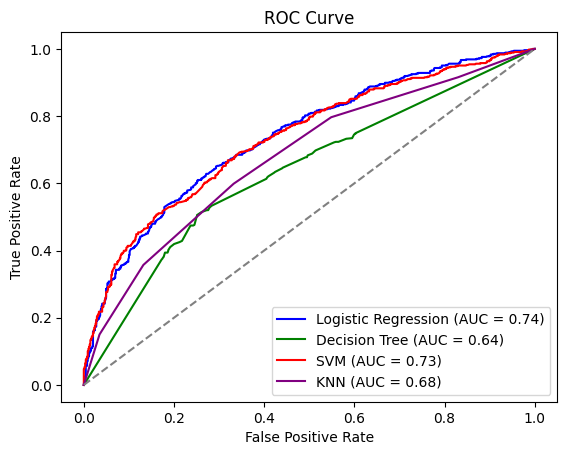

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# Initialize the classifiers
clf1 = LogisticRegression(random_state=123)
clf2 = DecisionTreeClassifier(random_state=321)
clf3 = SVC(probability=True, random_state=213)
clf4 = KNeighborsClassifier()

# Train the classifiers on the training data
clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)
clf4.fit(X_train, y_train)

# Obtain the predicted probabilities for each classifier
y_score1 = clf1.predict_proba(X_test)[:, 1]
y_score2 = clf2.predict_proba(X_test)[:, 1]
y_score3 = clf3.predict_proba(X_test)[:, 1]
y_score4 = clf4.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (fpr) and true positive rate (tpr) for each classifier
fpr1, tpr1, _ = roc_curve(y_test, y_score1)
fpr2, tpr2, _ = roc_curve(y_test, y_score2)
fpr3, tpr3, _ = roc_curve(y_test, y_score3)
fpr4, tpr4, _ = roc_curve(y_test, y_score4)

# Calculate the area under the curve (AUC) for each classifier
auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)
auc3 = auc(fpr3, tpr3)
auc4 = auc(fpr4, tpr4)

# Plot the ROC curves for each classifier
plt.plot(fpr1, tpr1, color='blue', label='Logistic Regression (AUC = %0.2f)' % auc1)
plt.plot(fpr2, tpr2, color='green', label='Decision Tree (AUC = %0.2f)' % auc2)
plt.plot(fpr3, tpr3, color='red', label='SVM (AUC = %0.2f)' % auc3)
plt.plot(fpr4, tpr4, color='purple', label='KNN (AUC = %0.2f)' % auc4)

# Plot the random guess line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Set the plot labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

In the above graph, Logistic Regression and SVM have higher AUC scores and their curves are closer to the top-left corner of the plot -> have better performance.

In [ ]:
df_b = df[df["race"]=="African-American"]
X_b = df_b[['age', 'c_charge_degree', 'race', 'sex', 'priors_count', 'juv_fel_count', 'juv_misd_count']]
y_b = df_b['two_year_recid']
X_b = pd.get_dummies(X_b)

df_w = df[df["race"]=="Caucasian"]
X_w = df_w[['age', 'c_charge_degree', 'race', 'sex', 'priors_count', 'juv_fel_count', 'juv_misd_count']]
y_w = df_w['two_year_recid']
X_w = pd.get_dummies(X_w)

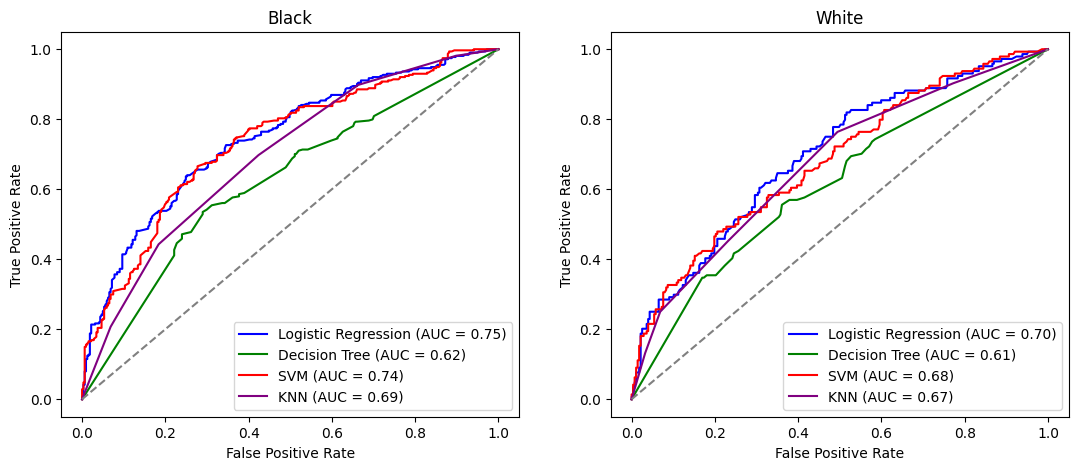

In [ ]:
# Black and White
def PlotROC(X, y, ax, title):
  # Split the dataset into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

  # Initialize the classifiers
  clf1 = LogisticRegression(random_state=123)
  clf2 = DecisionTreeClassifier(random_state=321)
  clf3 = SVC(probability=True, random_state=213)
  clf4 = KNeighborsClassifier()

  # Train the classifiers on the training data
  clf1.fit(X_train, y_train)
  clf2.fit(X_train, y_train)
  clf3.fit(X_train, y_train)
  clf4.fit(X_train, y_train)

  # Obtain the predicted probabilities for each classifier
  y_score1 = clf1.predict_proba(X_test)[:, 1]
  y_score2 = clf2.predict_proba(X_test)[:, 1]
  y_score3 = clf3.predict_proba(X_test)[:, 1]
  y_score4 = clf4.predict_proba(X_test)[:, 1]

  # Calculate the false positive rate (fpr) and true positive rate (tpr) for each classifier
  fpr1, tpr1, _ = roc_curve(y_test, y_score1)
  fpr2, tpr2, _ = roc_curve(y_test, y_score2)
  fpr3, tpr3, _ = roc_curve(y_test, y_score3)
  fpr4, tpr4, _ = roc_curve(y_test, y_score4)

  # Calculate the area under the curve (AUC) for each classifier
  auc1 = auc(fpr1, tpr1)
  auc2 = auc(fpr2, tpr2)
  auc3 = auc(fpr3, tpr3)
  auc4 = auc(fpr4, tpr4)

  # Plot the ROC curves for each classifier
  ax.plot(fpr1, tpr1, color='blue', label='Logistic Regression (AUC = %0.2f)' % auc1)
  ax.plot(fpr2, tpr2, color='green', label='Decision Tree (AUC = %0.2f)' % auc2)
  ax.plot(fpr3, tpr3, color='red', label='SVM (AUC = %0.2f)' % auc3)
  ax.plot(fpr4, tpr4, color='purple', label='KNN (AUC = %0.2f)' % auc4)

  # Plot the random guess line
  ax.plot([0, 1], [0, 1], linestyle='--', color='gray')

  # Set the plot labels and legend
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title(title)
  ax.legend(loc="lower right")

# Plot 2 graphs
fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(13, 5))
PlotROC(X_b, y_b, ax1, "Black")
PlotROC(X_w, y_w, ax2, "White")

- Logistic Regression and SVM perform best in both cases
- The classifer for black group is better than the white (AUC=0.75>0.72)

From the graphs above, we can see that ROC curves are different between black and white group. This is enough to identify the gap between the FPR in different groups, also for TPR. This reflects the different fairness of different algorithms.

Furthermore, we can use the *evaluate_fairness* function, to print detailed fairness metrics for each algorithm, to have a more clear view about the unfairness. This could be an advanced work that we have not accomplished yet.

## 3.5 Fairness evaluation(added)

In [ ]:
# Black and White
def calfair(X1, y1, X2, y2):
  # Split the dataset into training and testing sets
  X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=41)

  # Initialize the classifiers
  clf1 = LogisticRegression(random_state=123)
  clf2 = DecisionTreeClassifier(random_state=321)
  clf3 = SVC(probability=True, random_state=213)
  clf4 = KNeighborsClassifier()

  # Train the classifiers on the training data
  clf1.fit(X_train1, y_train1)
  clf2.fit(X_train1, y_train1)
  clf3.fit(X_train1, y_train1)
  clf4.fit(X_train1, y_train1)

  # Obtain the predicted probabilities for each classifier
  y_score11 = clf1.predict_proba(X_test1)[:, 1]
  y_score21 = clf2.predict_proba(X_test1)[:, 1]
  y_score31 = clf3.predict_proba(X_test1)[:, 1]
  y_score41 = clf4.predict_proba(X_test1)[:, 1]

  threshold_common = 0.5
  # TODO: Insert your code below this line
  y_pred_b1 = [True if prob >= threshold_common else False for prob in y_score11]  # Binary predictions based on threshold_common
  y_pred_b2 = [True if prob >= threshold_common else False for prob in y_score21]  # Binary predictions based on threshold_common
  y_pred_b3 = [True if prob >= threshold_common else False for prob in y_score31]  # Binary predictions based on threshold_common
  y_pred_b4 = [True if prob >= threshold_common else False for prob in y_score41]  # Binary predictions based on threshold_common

  # Split the dataset into training and testing sets
  X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=41)

  # Train the classifiers on the training data
  clf1.fit(X_train2, y_train2)
  clf2.fit(X_train2, y_train2)
  clf3.fit(X_train2, y_train2)
  clf4.fit(X_train2, y_train2)


 # Obtain the predicted probabilities for each classifier
  y_score12 = clf1.predict_proba(X_test2)[:, 1]
  y_score22 = clf2.predict_proba(X_test2)[:, 1]
  y_score32 = clf3.predict_proba(X_test2)[:, 1]
  y_score42 = clf4.predict_proba(X_test2)[:, 1]

  # TODO: Insert your code below this line
  y_pred_w1 = [True if prob >= threshold_common else False for prob in y_score12]  # Binary predictions based on threshold_common
  y_pred_w2 = [True if prob >= threshold_common else False for prob in y_score22]  # Binary predictions based on threshold_common
  y_pred_w3 = [True if prob >= threshold_common else False for prob in y_score32]  # Binary predictions based on threshold_common
  y_pred_w4 = [True if prob >= threshold_common else False for prob in y_score42]  # Binary predictions based on threshold_common

  y_test_b = [True if t==1 else False for t in y_test1]
  y_test_w = [True if t==1 else False for t in y_test2]

  # print_metrics is contained in this function we implemented
  print("==========LogisticRegression==========")
  evaluate_fairness(y_pred_w1, y_test_w, y_pred_b1, y_test_b)
  print("\n")
  print("==========DecisionTree==========")
  evaluate_fairness(y_pred_w2, y_test_w, y_pred_b2, y_test_b)
  print("\n")
  print("==========SVC==========")
  evaluate_fairness(y_pred_w3, y_test_w, y_pred_b3, y_test_b)
  print("\n")
  print("==========KNeighbour==========")
  evaluate_fairness(y_pred_w4, y_test_w, y_pred_b4, y_test_b)

calfair(X_b, y_b, X_w, y_w)


==========LogisticRegression==========
---------Result of Print_Metrics in group 1---------
Accuracy:  0.667458432304038
PPV:  0.5208333333333334
FPR:  0.16606498194945848
FNR:  0.6527777777777778

---------Result of Print_Metrics in group 2---------
Accuracy:  0.6692913385826772
PPV:  0.6538461538461539
FPR:  0.3644859813084112
FNR:  0.2961783439490446

---------Independence performance---------
positive rate 1 is 0.228029, positive rate 2 is 0.532283, difference is 0.304255
---------Separation performance---------
FPR 1 is 0.166065, FPR 2 is 0.364486, difference is 0.198421
FNR 1 is 0.652778, FNR 2 is 0.296178, difference is 0.356599
---------Sufficiency performance---------
TPR 1 is 0.347222, TPR 2 is 0.703822, difference is 0.356599
TNR 1 is 0.833935, TNR 2 is 0.635514, difference is 0.198421


==========DecisionTree==========
---------Result of Print_Metrics in group 1---------
Accuracy:  0.667458432304038
PPV:  0.5188679245283019
FPR:  0.18411552346570398
FNR:  0.6180555555555556

So Decision Tree has the best fairness

# 4 A FAIR classifier

We use the same pipeline given in the above example code, and add the fairness aspects to the code.

To implement the "fairness", we could interfere with pre/in/post-processing steps.

We tried a simple "reweighting" pre-processing in part 1 but failed, but have a good result for a post-processing technique called "ROC post-processing algorithm".

## 4.1 Reweighting the training data to balance the groups (pre-processing)

The idea is simple. We assign a weight in the training set to the black group, which is equal to 1/(black_sample_size - white_sample_size). We tried a few random weight but the result is not promising


- unwanted bias in training data yeilds models with unwanted bias
- Undersampling and oversampling

In reweighing pre-processing algorithm, the weight ratio is typically chosen such that the unprivileged group has a higher weight and the privileged group has a lower weight. This can be achieved by setting the weight for the unprivileged group to be larger than the weight for the privileged group.

In the case where 'African-American' group is considered as the unprivileged group, the weight ratio can be chosen by calculating the ratio of the number of samples in the privileged group to the number of samples in the unprivileged group. For example, if there are 100 samples in the privileged group and 200 samples in the unprivileged group, then the weight ratio can be set as 100/200 = 0.5. This means that the weight for the unprivileged group will be twice that of the privileged group. However, the exact weight ratio to use will depend on the specific dataset and the degree of bias that needs to be mitigated. It may require some experimentation to find the optimal weight ratio.

- protected features: We do this by creating binary variables using the sensitive attributes. We define the variable so that 1 represents a privileged group and 0 represents an unprivileged group

- About sensitive feature: It depends on the specific algorithm and approach used for mitigating bias. Some algorithms, such as adversarial debiasing and equalized odds, explicitly involve the sensitive attribute in the training process. However, other approaches, such as reweighing or post-processing, do not require the sensitive attribute to be included in the training process. In the case of the Reject Option Classification algorithm, the sensitive attribute is not directly involved in the training process. Instead, the algorithm involves re-calibrating the output of an existing classifier to adjust for differences in group distributions. Therefore, the sensitive attribute is only used to select the threshold value for classification and is not included in the actual training process.

- In the reweighing pre-processing algorithm, the weight ratio should be determined based on the ratio of the number of instances in the underrepresented group (in your case, African-American) to the number of instances in the overrepresented group (in your case, Caucasian). To achieve balance between the two groups, the weight ratio should be set to the inverse of this ratio. In your case, if the training size of African-American is 1.5 times that of Caucasian, then the weight ratio should be set to 2/3. This means that instances from the African-American group should be weighted 2/3 of instances from the Caucasian group during the training phase.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import defaultdict

FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "priors_count", "c_charge_degree"] #features to be used for classification
CONT_VARIABLES = ["priors_count"] # continuous features, will need to be handled separately from categorical features, categorical features will be encoded using one-hot
CLASS_FEATURE = "two_year_recid" # the decision variable
SENSITIVE_ATTRS = ["race"]

y = data[CLASS_FEATURE]
X = np.array([]).reshape(len(y), 0) # empty array with num rows same as num examples, will hstack the features to it
x_control = defaultdict(list)

for attr in FEATURES_CLASSIFICATION:
    vals = data[attr]
    if attr in CONT_VARIABLES:
        vals = [float(v) for v in vals]
        vals = preprocessing.scale(vals) # 0 mean and 1 variance  
        vals = np.reshape(vals, (len(y), -1)) # convert from 1-d arr to a 2-d arr with one col

    else: # this encodes categorical variables in a numerical way -- there are other ways to do it
        enc = preprocessing.LabelBinarizer()
        enc.fit(vals)
        vals = enc.transform(vals)

    # add to learnable features
    X = np.hstack((X, vals))

    
# the following is a very dirty way to keep track of the race after the train_test_split
ind = data["race"]=="African-American"
X_b = X[ind] 
y_b = y[ind]
ind = data["race"]=="Caucasian"
X_w = X[ind]
y_w = y[ind]
ind = [data["race"][i]!="Caucasian" and data["race"][i]!="African-American" for i in range(len(y))]
X_n = X[ind]        
y_n = y[ind]
    
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.3, random_state=1234)
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_w, y_w, test_size=0.3, random_state=5678)
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, y_n, test_size=0.3, random_state=9012)

# Calculate the ratio for reweighting
# unprivileged group: African-American
# privileged group: Caucasian

weight = len(X_train_b) / len(X_train_w)

In [ ]:
weight

1.5095108695652173

In [ ]:
# Assign the weight to the black group
X_train = np.vstack((X_train_b*(1/weight), X_train_w, X_train_n))
y_train = np.hstack((y_train_b, y_train_w, y_train_n))

X_test = np.vstack((X_test_b, X_test_w, X_test_n))
y_test = np.hstack((y_test_b, y_test_w, y_test_n))

In [ ]:
X_train[0]

array([ 0.66246625,  0.        ,  0.        ,  0.66246625,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.66246625,
       -0.31373958,  0.        ])

In [ ]:
# # Train model
model = LogisticRegression(C=0.1)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))
y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

0.6605504587155964
Accuracy: 0.6605504587155964


Text(0, 0.5, 'TPR')

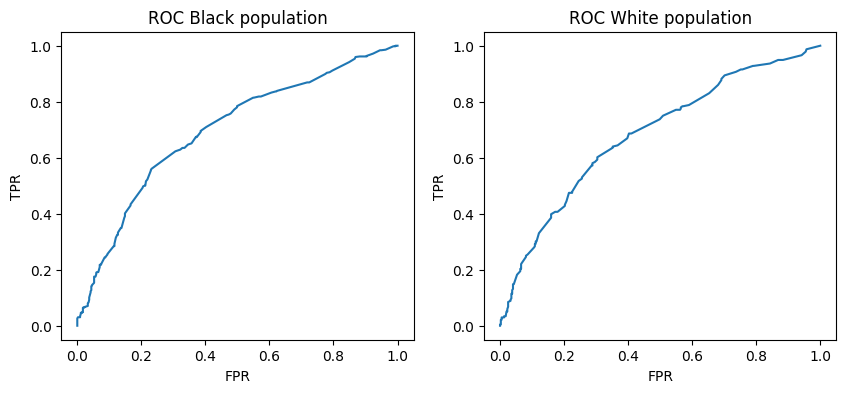

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

scores = model.predict_proba(X_test)
scores_b = model.predict_proba(X_test_b)
scores_w = model.predict_proba(X_test_w)

# Normal
sb = scores_b[:,1]
sw = scores_w[:,1]

fpr, tpr, thresholds = roc_curve(y_test_b, sb)

fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(10, 4))
#fig.suptitle('Horizontally stacked subplots')

ax1.plot(fpr, tpr)

ax1.set_title('ROC Black population')
ax1.set_xlabel("FPR")
ax1.set_ylabel("TPR")

fpr, tpr, thresholds = roc_curve(y_test_w, sw)

ax2.plot(fpr, tpr)

ax2.set_title('ROC White population')
ax2.set_xlabel("FPR")
ax2.set_ylabel("TPR")

We can finally check the fairness of this simple logistic regression, when choosing an arbitrary threshold common to the two groups. 

<span style="color:red">TODO</span>: Compute the predictions for a common threshold (threshold_common), then compute the PPV, TPR, FPR (you can use the print_metrics function from above). Comment. 

PPV measures the proportion of true positives (i.e., correct predictions that the person will reoffend) among all positive predictions (i.e., all predicted reoffenders). A fair classifier would have similar PPV across different groups, indicating that the rate of correct predictions is similar across different groups.

FPR measures the proportion of false positives (i.e., incorrect predictions that the person will reoffend) among all negative predictions (i.e., all predicted non-reoffenders). A fair classifier would have similar FPR across different groups, indicating that the rate of incorrect predictions is similar across different groups.

FNR measures the proportion of false negatives (i.e., incorrect predictions that the person will not reoffend) among all positive predictions (i.e., all predicted reoffenders). A fair classifier would have similar FNR across different groups, indicating that the rate of missed predictions is similar across different groups.

In summary, fairness can be evaluated using PPV, FPR, and FNR, among other metrics, and a fair classifier would have similar values for these metrics across different groups.

In [ ]:
threshold_common = 0.45
# TODO: Insert your code below this line
y_pred_b = [True if prob >= threshold_common else False for prob in sb]  # Binary predictions based on threshold_common
y_pred_w = [True if prob >= threshold_common else False for prob in sw]  # Binary predictions based on threshold_common

y_test_b1 = [True if t==1 else False for t in y_test_b]
y_test_w1 = [True if t==1 else False for t in y_test_w]

print("==================Modified Result======================")
evaluate_fairness(y_pred_w, y_test_w1, y_pred_b, y_test_b1)

print('''=============Normal Classifier Result=================
---------Result of Print_Metrics in group 1---------
Accuracy:  0.6687797147385103
PPV:  0.5828220858895705
FPR:  0.17215189873417722
FNR:  0.597457627118644

---------Result of Print_Metrics in group 2---------
Accuracy:  0.6505771248688352
PPV:  0.6687370600414079
FPR:  0.350109409190372
FNR:  0.3487903225806452

---------Independence performance---------
positive rate 1 is 0.258320, positive rate 2 is 0.506821, difference is 0.248500
---------Separation performance---------
FPR 1 is 0.172152, FPR 2 is 0.350109, difference is 0.177958
FNR 1 is 0.597458, FNR 2 is 0.348790, difference is 0.248667
---------Sufficiency performance---------
TPR 1 is 0.402542, TPR 2 is 0.651210, difference is 0.248667
TNR 1 is 0.827848, TNR 2 is 0.649891, difference is 0.177958
''')

==================Modified Result======================
---------Result of Print_Metrics in group 1---------
Accuracy:  0.6640253565768621
PPV:  0.5530973451327433
FPR:  0.25569620253164554
FNR:  0.4703389830508475

---------Result of Print_Metrics in group 2---------
Accuracy:  0.646379853095488
PPV:  0.6292682926829268
FPR:  0.4989059080962801
FNR:  0.21975806451612903

---------Independence performance---------
positive rate 1 is 0.358162, positive rate 2 is 0.645331, difference is 0.287169
---------Separation performance---------
FPR 1 is 0.255696, FPR 2 is 0.498906, difference is 0.243210
FNR 1 is 0.470339, FNR 2 is 0.219758, difference is 0.250581
---------Sufficiency performance---------
TPR 1 is 0.529661, TPR 2 is 0.780242, difference is 0.250581
TNR 1 is 0.744304, TNR 2 is 0.501094, difference is 0.243210
=============Normal Classifier Result=================
---------Result of Print_Metrics in group 1---------
Accuracy:  0.6687797147385103
PPV:  0.5828220858895705
FPR:  0.172

The fairness is also evaluated using *evaluate_fairness* function that we implemented above. We can see that the difference of pre-processed result is even larger than the original classifier. So we know that the pre-processing failed to improve fairness. We will try another method(post-processing) after.

## 4.2 Reject Option Classification (post-processing)

We add a function named "def roc_postprocessing(y_pred_probs, p)" and use this to the output of the Logistic Regression algorithm to get the final output. Then we compare it to normal version.

The Reject Option Classification (ROC) post-processing algorithm is a bias mitigation technique that aims to achieve group fairness by adjusting the classification threshold for different groups.

The algorithm defines 2 thresholds: a low threshold and a high threshold.  

- Instances with predicted probabilities < the low threshold -> rejected and labeled as "uncertain". 
- Instances with predicted probabilities > the high threshold are accepted and labeled as "positive".
- Instances with predicted probabilities between the low and high thresholds are subject to the ROC post-processing step.

Next, for each group, the ROC algorithm computes the TPR and FPR at different threshold values. The threshold is then adjusted for each group such that the TPR and FPR are equal. This ensures that the algorithm is fair across all groups.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import defaultdict

FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "priors_count", "c_charge_degree"] #features to be used for classification
CONT_VARIABLES = ["priors_count"] # continuous features, will need to be handled separately from categorical features, categorical features will be encoded using one-hot
CLASS_FEATURE = "two_year_recid" # the decision variable
SENSITIVE_ATTRS = ["race"]

y = data[CLASS_FEATURE]
X = np.array([]).reshape(len(y), 0) # empty array with num rows same as num examples, will hstack the features to it
x_control = defaultdict(list)

for attr in FEATURES_CLASSIFICATION:
    vals = data[attr]
    if attr in CONT_VARIABLES:
        vals = [float(v) for v in vals]
        vals = preprocessing.scale(vals) # 0 mean and 1 variance  
        vals = np.reshape(vals, (len(y), -1)) # convert from 1-d arr to a 2-d arr with one col

    else: # this encodes categorical variables in a numerical way -- there are other ways to do it
        enc = preprocessing.LabelBinarizer()
        enc.fit(vals)
        vals = enc.transform(vals)

    # add to learnable features
    X = np.hstack((X, vals))

    
# the following is a very dirty way to keep track of the race after the train_test_split
ind = data["race"]=="African-American"
X_b = X[ind] 
y_b = y[ind]
ind = data["race"]=="Caucasian"
X_w = X[ind]
y_w = y[ind]
ind = [data["race"][i]!="Caucasian" and data["race"][i]!="African-American" for i in range(len(y))]
X_n = X[ind]        
y_n = y[ind]
    
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.3, random_state=1234)
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_w, y_w, test_size=0.3, random_state=5678)
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, y_n, test_size=0.3, random_state=9012)

X_train = np.vstack((X_train_b, X_train_w, X_train_n))
y_train = np.hstack((y_train_b, y_train_w, y_train_n))

X_test = np.vstack((X_test_b, X_test_w, X_test_n))
y_test = np.hstack((y_test_b, y_test_w, y_test_n))

In [ ]:
# # Train model
model = LogisticRegression(C=0.1)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))
y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

0.6562331354560172
Accuracy: 0.6562331354560172


Implementation of the ROC post-processing algorithm: It computes the optimal threshold for binary predictions based on the given probability scores and a fairness parameter p. Then it applies this threshold to obtain the binary predictions.

The np.percentile(y_pred_probs, (1 - p) * 100) line computes the 100*(1-p) percentile of the y_pred_probs. This corresponds to the threshold that separates the top p*100% of the scores from the rest. For example, if p=0.2, then the threshold is the score that separates the top 20% from the bottom 80%.

The y_pred_probs > threshold line creates a boolean mask that selects all the scores that are greater than the threshold. This results in an array of True and False values. Finally, the (y_pred_probs > threshold).astype(int) line casts this boolean array to an integer array where the True values are converted to 1 and the False values are converted to 0.

Overall, this algorithm is used to achieve a certain level of fairness in binary predictions by adjusting the threshold based on the fairness parameter p.

In [ ]:
def roc_postprocessing(y_pred_probs, p):
    # Compute the optimal threshold for the ROC post-processing algorithm
    n = len(y_pred_probs)

    # Adjust new threshold with p; higher p more fairness lower accuracy
    threshold = np.percentile(y_pred_probs, (1 - p) * 100)
    print("ROC threshold : ", threshold)

    # Apply the threshold to obtain binary predictions
    y_pred = (y_pred_probs > threshold).astype(int)
    return y_pred

How to choose p?

The parameter p in the ROC post-processing algorithm is a hyperparameter that determines the degree of fairness and accuracy tradeoff. A smaller value of p leads to more fairness but lower accuracy, while a larger value of p leads to higher accuracy but less fairness.

The value of p depends on the specific application and the degree of importance placed on fairness versus accuracy. It can be chosen by performing a grid search over a range of values and selecting the value that provides the desired balance between fairness and accuracy. Alternatively, domain expertise and ethical considerations can be used to select an appropriate value for p.

In general, a common practice is to choose p such that the difference in true positive rate (TPR) between the privileged and unprivileged groups is below a certain threshold, e.g., 5%. This ensures that the algorithm achieves a reasonable level of fairness while maintaining a high level of accuracy.

ROC threshold :  0.368153721244698
ROC threshold :  0.45148867967686235
ROC threshold :  0.3373508025468774


Text(0, 0.5, 'TPR')

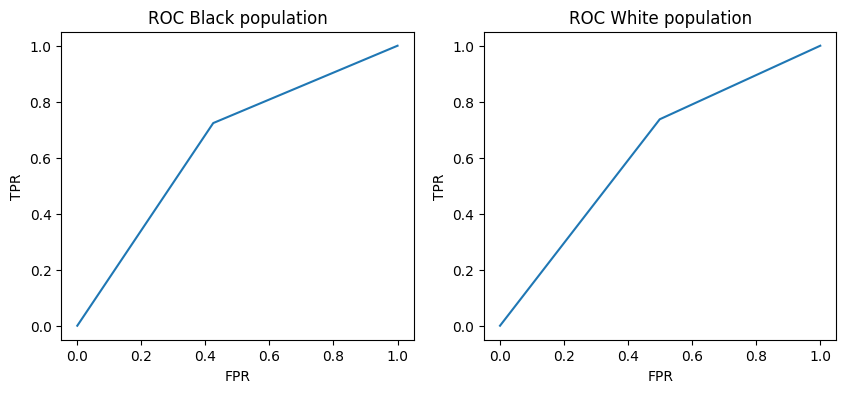

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

scores = model.predict_proba(X_test)
scores_b = model.predict_proba(X_test_b)
scores_w = model.predict_proba(X_test_w)

# Normal
sb = scores_b[:,1]
sw = scores_w[:,1]

# Reject Option Classification (post-processing)
p = 0.4
s = roc_postprocessing(scores[:,1],p)
sb = roc_postprocessing(scores_b[:,1],p)
sw = roc_postprocessing(scores_w[:,1],p)

fpr, tpr, thresholds = roc_curve(y_test_b, sb)

fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(10, 4))
#fig.suptitle('Horizontally stacked subplots')

ax1.plot(fpr, tpr)

ax1.set_title('ROC Black population')
ax1.set_xlabel("FPR")
ax1.set_ylabel("TPR")

fpr, tpr, thresholds = roc_curve(y_test_w, sw)

ax2.plot(fpr, tpr)

ax2.set_title('ROC White population')
ax2.set_xlabel("FPR")
ax2.set_ylabel("TPR")

PPV measures the proportion of true positives (i.e., correct predictions that the person will reoffend) among all positive predictions (i.e., all predicted reoffenders). A fair classifier would have similar PPV across different groups, indicating that the rate of correct predictions is similar across different groups.

FPR measures the proportion of false positives (i.e., incorrect predictions that the person will reoffend) among all negative predictions (i.e., all predicted non-reoffenders). A fair classifier would have similar FPR across different groups, indicating that the rate of incorrect predictions is similar across different groups.

FNR measures the proportion of false negatives (i.e., incorrect predictions that the person will not reoffend) among all positive predictions (i.e., all predicted reoffenders). A fair classifier would have similar FNR across different groups, indicating that the rate of missed predictions is similar across different groups.

In summary, fairness can be evaluated using PPV, FPR, and FNR, among other metrics, and a fair classifier would have similar values for these metrics across different groups.

In [ ]:
threshold_common = 0.5
ROC_threshold =  0.4819309854926621

# TODO: Insert your code below this line
y_pred_b = [True if prob >= threshold_common else False for prob in sb]  # Binary predictions based on threshold_common
y_pred_w = [True if prob >= threshold_common else False for prob in sw]  # Binary predictions based on threshold_common

y_test_b1 = [True if t==1 else False for t in y_test_b]
y_test_w1 = [True if t==1 else False for t in y_test_w]

#y_pred_b = [True if prob >= ROC_threshold else False for prob in scores_b[:,1]]  # Binary predictions based on threshold_common
#y_pred_w = [True if prob >= ROC_threshold else False for prob in scores_w[:,1]]  # Binary predictions based on threshold_common

print("================Modified Result==================")
evaluate_fairness(y_pred_w, y_test_w1, y_pred_b, y_test_b1)

y_pred_b = [True if prob >= threshold_common else False for prob in scores_b[:,1]]  # Binary predictions based on threshold_common
y_pred_w = [True if prob >= threshold_common else False for prob in scores_w[:,1]]  # Binary predictions based on threshold_common

print("\n============Normal Classifier Result=============")
evaluate_fairness(y_pred_w, y_test_w1, y_pred_b, y_test_b1)

================Modified Result==================
---------Result of Print_Metrics in group 1---------
Accuracy:  0.589540412044374
PPV:  0.46900269541778977
FPR:  0.49873417721518987
FNR:  0.2627118644067797

---------Result of Print_Metrics in group 2---------
Accuracy:  0.6526757607555089
PPV:  0.6491862567811935
FPR:  0.424507658643326
FNR:  0.2762096774193548

---------Independence performance---------
positive rate 1 is 0.587956, positive rate 2 is 0.580273, difference is 0.007683
---------Separation performance---------
FPR 1 is 0.498734, FPR 2 is 0.424508, difference is 0.074227
FNR 1 is 0.262712, FNR 2 is 0.276210, difference is 0.013498
---------Sufficiency performance---------
TPR 1 is 0.737288, TPR 2 is 0.723790, difference is 0.013498
TNR 1 is 0.501266, TNR 2 is 0.575492, difference is 0.074227

============Normal Classifier Result=============
---------Result of Print_Metrics in group 1---------
Accuracy:  0.6687797147385103
PPV:  0.5828220858895705
FPR:  0.17215189873417

In the Modified Result part, we could see that the difference of the rate FPR, FNR between black and white groups are significantly reduced, compared to the Normal Result, while the accuracy rate stays roughly the same.

With the evaluation of evaluate_fairness, we can see that the independence, separation and sufficiency difference all become very small compared to the original classifier. But the Accuracy is almost the same(even a bit higher).

Therefore, the algorithm is indeed improved after the ROC post-processing implementation.

